# 近似差分隐私

```{admonition} 学习目标
阅读本章后，您将能够：
- 定义近似差分隐私
- 解释近似差分隐私和纯粹差分隐私的区别
- 描述近似差分隐私的优势和劣势
- 描述和计算向量值查询的L1和L2敏感度
- 定义和使用高斯机制
- 应用高级组合性
```
近似差分隐私（Approximate Differential Privacy）{cite}`dwork2006`，也称$(\epsilon, \delta)$-差分隐私，其定义如下所述：

\begin{align}
\mathsf{Pr}[F(x) = S] \leq e^\epsilon \mathsf{Pr}[F(x') = s] + \delta
\end{align}

新出现的隐私参数$\delta$表示不满足此近似差分隐私定义的"失败概率"。我们有$1-\delta$的概率获得等价于纯粹差分隐私的隐私保护程度。同时，我们有$\delta$的概率不满足隐私参数为$\epsilon$的纯粹差分隐私。换句话说：

- 满足$\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = s]} \leq e^\epsilon$的概率为$1-\delta$
- 不能保证满足上述不等式的概率为$\delta$

上述定义看起来有点吓人！我们有$\delta$的概率无法保证差分隐私，这意味着我们甚至可能有$\delta$的概率泄露整个敏感数据集！因此，我们通常要求$\delta$很小。一般来说，我们要求$\delta$的取值小于等于$\frac{1}{n^2}$，其中$n$表示数据集的总大小。此外，我们还将看到，实际使用的$(\epsilon, \delta)$-差分隐私机制不会像定义所描述的那样吓人，不会出现一旦失败就引发灾难性后果的情况。实际上，该机制会*温和地*失败，一般不会造成诸如泄露整个数据集之类的严重后果。

确实*可以*构造出此类机制，并可以证明构造出的机制确实满足$(\epsilon, \delta)$-差分隐私。我们将在本章后续部分看到实际的机制构造方法。

## 近似差分隐私的性质

近似差分隐私拥有和纯粹$\epsilon$-差分隐私相似的特性。它同样满足**串行组合性**：

- 如果$F_1(x)$满足$(\epsilon_1, \delta_1)$-差分隐私
- 同时$F_2(x)$满足$(\epsilon_2, \delta_2)$-差分隐私
- 则发布两个结果的机制$G(x) = (F_1(x), F_2(x))$满足$(\epsilon_1+\epsilon_2, \delta_1 + \delta_2)$-差分隐私

与纯粹$\epsilon$-差分隐私相比，近似差分隐私串行组合性唯一的不同之处在于需要分别对$\delta$和$\epsilon$相加。近似差分隐私同样满足后处理性和并行组合性。

## 高斯机制

可以用高斯机制替代拉普拉斯机制。高斯机制增加的不是拉普拉斯噪声，而是高斯噪声。高斯机制*无法*满足纯粹$\epsilon$-差分隐私，但可以满足$(\epsilon, \delta)$-差分隐私。对于一个返回数值的函数$f(x)$，应用下述定义的高斯机制，可以得到满足$(\epsilon, \delta)$-差分隐私的$F(x)$：

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2)\\
\text{where } \sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}
\end{align}

其中$s$是$f$的敏感度，$\mathcal{N}(\sigma^2)$表示均值为0，方差为$\sigma^2$的高斯（正态）分布采样结果。请注意，这里的$\log$表示自然对数（本书其他地方出现的$\log$同样表示自然对数）。

对于实值函数$f : D \rightarrow \mathbb{R}$，我们可以按照与拉普拉斯机制完全相同的方法使用高斯机制。在相同的$\epsilon$取值下，很容易对比两种机制的应用效果。

In [ ]:
%matplotlib inline
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np

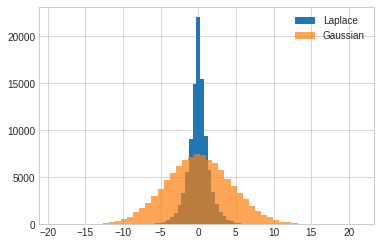

In [3]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]

plt.hist(vals_laplace, bins=50, label='拉普拉斯')
plt.hist(vals_gauss, bins=50, alpha=.7, label='高斯');
plt.legend();

这里我们画出了$\epsilon = 1$时，拉普拉斯机制和高斯机制的经验概率密度函数，我们这里令高斯机制的$\delta = 10^{-5}$。

与拉普拉斯机制的曲线相比，高斯机制的曲线看起来更"平"。当应用高斯机制时，我们更有可能得到远离真实值的差分隐私输出结果，而拉普拉斯机制的输出结果与真实值更接近一些（相比之下，拉普拉斯机制的曲线看起来更"尖"）。

因此，高斯机制有两个严重的缺点：其一，该机制需要使用宽松的$(\epsilon, \delta)$-差分隐私定义；其二，该机制的准确性不如拉普拉斯机制。既然如此，为什么我们还需要高斯机制呢？

## 向量值函数及其敏感度

截至目前，我们考虑的都是实值函数（即输出总为单一实数的函数）。此类函数的形式为：$f : D \rightarrow \mathbb{R}$。拉普拉斯机制和高斯机制都可以扩展到形式为：$f : D \rightarrow \mathbb{R}^k$的*向量值*函数，即输出为实数向量的函数。我们可以将直方图看作向量值函数，其返回的向量表示直方图各个分箱的计数值。

我们在前面提到，函数的*敏感度*定义为：

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lvert f(x) - f(x') \rvert
\end{align}

我们如何定义向量值函数的敏感度呢？

考虑表达式$f(x) - f(x')$。如果$f$是向量值函数，那么该表达式表示的是两个向量之间的差，可以通过计算对应位置元素之间的差来得到（两个长度为$k$的向量差是一个长度为$k$的新向量）。这个新向量就是$f(x)$和$f(x')$之间的距离。

该向量的标量长度就是$f$的敏感度。有很多计算向量标量长度的方法。我们将使用两种方法：$L1$范数和$L2$范数。

### L1和L2范数

给定长度为$k$的向量$V$，其$L1$范数定义为$\lVert V \rVert_1 = \sum_{i=1}^k \lvert V_i \rvert$（即向量各个元素的和）。在二维空间中，两个向量之差的$L1$范数就是它们的"曼哈顿距离"。

给定长度为$k$的向量$V$，其$L2$范数定义为$\lVert V \rVert_2 = \sqrt{\sum_{i=1}^k V_i^2}$（即向量各个元素平方和再求平方根）。在二维空间中，两个向量之差的$L2$范数就是它们的"欧氏距离"。$L2$范数总是小于或等于$L1$范数。

### L1和L2敏感度

向量值函数$f$的$L1$敏感度为：

\begin{align}
GS(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_1
\end{align}

此敏感度等于向量各个元素敏感度的和。举例来说，如果我们定义了一个向量值函数$f$，其返回一个长度为$k$的向量，且向量中各个元素的敏感度均为1，则$f$的$L1$敏感度为$k$。

类似地，向量值函数$f$的$L2$敏感度为：

\begin{align}
GS_2(f) = \max_{d(x,x') \leq 1} \lVert f(x) - f(x') \rVert_2
\end{align}

同样是上述的例子，向量值函数$f$返回一个长度为$k$的向量，且向量中各个元素的敏感度均为1，则$f$的$L2$敏感度为$\sqrt{k}$。对于长向量，$L2$敏感度显然比$L1$敏感度低得多！在机器学习算法（返回的向量有时包含成千上万个元素）等应用中，$L2$敏感度*显著*低于$L1$敏感度。

### 选择L1还是L2

如之前所述，拉普拉斯机制和高斯机制都可以扩展到向量值函数。然而，这两种机制的扩展结果间有一个关键差异点：向量值拉普拉斯机制**需要**使用$L1$敏感度，而向量值高斯机制既可以使用$L1$敏感度，也可以使用$L2$敏感度。这是高斯机制的一个重要优势。对于$L2$敏感度远低于$L1$敏感度的应用来说，高斯机制添加的噪声要*小*得多。

- **向量拉普拉斯机制**发布的是$f(x) + (Y_1, \dots, Y_k)$，其中$Y_i$是采样自拉普拉斯分布的独立同分布噪声，噪声尺度为$\frac{s}{\epsilon}$，其中$s$是$f$的$L1$敏感度。
- **向量高斯机制**发布的是$f(x) + (Y_1, \dots, Y_k)$，其中$Y_i$是采样自高斯分布的独立同分布噪声，且$\sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$，其中$s$是$f$的$L2$的敏感度。

## 灾难机制

$(\epsilon, \delta)$-差分隐私定义称，满足此差分隐私定义的机制必须以$1-\delta$的概率"表现良好"。但这也意味着此机制可以有$\delta$的概率执行任何操作。"失败概率"的存在令人无比担忧，因为满足宽松定义的差分隐私机制总可能（即使发生的概率很低）给出糟糕的输出结果。

考虑如下机制，我们称之为*灾难机制*（Catastrophe Mechanism）：

\begin{align}
F(q, x) =\;& \text{在0到1之间均匀随机地采样得到一个数$r$}\\
&\text{如果 } r < \delta, \text{返回 } x\\
&\text{否则，返回 } q(x) + \text{Lap}(s/\epsilon), \text{其中$s$是$q$的敏感度}\\
\end{align}

灾难机制有$1-\delta$的概率满足$\epsilon$-差分隐私。然而，灾难机制同时有$\delta$的概率*泄露无噪声的整个数据集*。尽管该机制满足近似差分隐私定义，但我们在实际中不太可能会应用此机制。

幸运的是，大多数$(\epsilon, \delta)$-差分隐私机制不会出现类似的灾难性失效情况。例如，高斯机制就不会真的发布整个数据集。高斯机制只是有$\delta$的概率不会*严格地*满足$\epsilon$-差分隐私，而是满足某个值$c$下的$c\epsilon$-差分隐私。

因此，高斯机制会很*温和地*失败，而不会灾难性地失败。因此，与灾难机制相比，我们有理由相信高斯机制可以为我们提供更好的隐私保护。我们后续还将看到差分隐私的另一种宽松定义方法。此定义可以区分温和性失败机制（如高斯机制）和灾难性失败机制（如灾难机制）。

## 高级组合性

我们已经学习了差分隐私机制的两种组合方式：串行组合性和并行组合性。事实证明，$(\epsilon, \delta)$-差分隐私引入了差分隐私机制串行组合性的一种新分析方法，此分析方法可以进一步降低隐私消耗量。

高级组合定理{cite}`dwork2010`通常用$k$-*折叠适应性组合*（$k$-fold Adaptive Composition）机制来描述。$k$-折叠适应性组合指的是将一系列机制$m_1, \dots, m_k$组合起来，这些机制满足下述条件：

- *适应性*：可以根据所有前述机制$m_1, \dots, m_{i-1}$的输出来选择下一个机制$m_i$
- *组合性*：每个机制$m_i$的输入既包括隐私数据集，也包括前述机制的所有输出

迭代程序（如循环或递归函数）几乎都是$k$-折叠适应性组合的实例。例如，一个执行1000轮的`for`循环是1000-折叠适应性组合。再举一个更特殊的例子，平均攻击也是$k$-折叠适应性组合：

In [8]:
# 此攻击针对的是敏感度为1的问询
def avg_attack(query, epsilon, k):
    results = [query + np.random.laplace(loc=0, scale=1/epsilon) for i in range(k)]
    return np.mean(results)

avg_attack(10, 1, 500)

10.070538197421769

在这个例子中，我们提前确定好了机制的组合顺序（我们每次都使用相同的机制），且$k = 500$。

标准串行组合定理称，该机制的总隐私消耗量为$k\epsilon$（本例的总隐私消耗量为$500 \epsilon$）。

高级组合定理称：

- 如果$k$-折叠适应性组合$m_1, \dots, m_k$中的每一个机制$m_i$都满足$\epsilon$-差分隐私
- 则对于任意$\delta \geq 0$，整个$k$-折叠适应性组合满足$(\epsilon', \delta')$-差分隐私，其中：

\begin{align}
\epsilon' = \epsilon \sqrt{2k \ln(1/\delta')} + k \epsilon (e^{\epsilon} - 1)
\end{align}

根据前面的例子，将$\epsilon = 1$代入到表达式中，并设置$\delta' = 10^{-5}$，我们有：

\begin{align}
\epsilon' =& \sqrt{1000 \ln(100000)} + 500 \times (e - 1)\\
\approx& 966.44
\end{align}

因此，*对于相同机制*，应用高级组合性得到的$\epsilon'$下界远低于应用串行组合性得到的下界。这意味着什么呢？这意味着串行组合性得到的隐私消耗量下界是*宽松*的。与*实际*隐私消耗相比，串行组合性得到的下界不够紧致。事实上，高级组合性得到的下界也是宽松的，此下界只是比串行组合性给出的下界*稍显*紧致一些。

需要着重强调的是，得到的两种隐私消耗量上界在技术角度看不具有可比性，因为高级组合性引入了$\delta$。但当$\delta$很小时，我们通常可以比较两种方法给出的$\epsilon$。

既然如此，我们应该*总是*使用高级组合性吗？*并非如此*。我们分别对于不同的$k$值计算隐私消耗量，绘制串行组合性和高级组合性的*总隐私消耗*图。

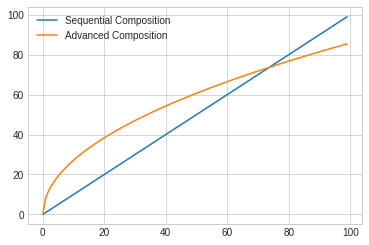

In [13]:
epsilon = 1
delta = 10e-5

def adv_comp(k):
    return 2*epsilon*np.sqrt(2*k*np.log(1/delta))

def seq_comp(k):
    return k*epsilon

plt.plot([seq_comp(k) for k in range(100)], label='串行组合性')
plt.plot([adv_comp(k) for k in range(100)], label='高级组合性')
plt.legend();

事实证明，当$k$小于70时，标准的串行组合性比高级组合性得到的总隐私消耗量更小。因此，仅当$k$比较大时（如大于100时），高级组合性才会有用武之地。不过，当$k$非常大时，高级组合性可以显露出*巨大*的优势。

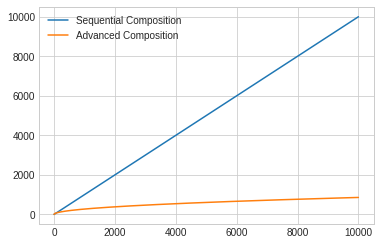

In [14]:
plt.plot([seq_comp(k) for k in range(10000)], label='串行组合性')
plt.plot([adv_comp(k) for k in range(10000)], label='高级组合性')
plt.legend();

## 近似差分隐私的高级组合性

当使用高级组合性时，前述要求各个机制均需满足纯粹$\epsilon$-差分隐私。然而，如果各个机制满足$(\epsilon, \delta)$-差分隐私，高级组合定理同样适用。高级组合定理更一般的描述如下（{cite}`dwork2010`, 定理3.20）：

- 如果$k$-折叠适应性组合$m_1, \dots, m_k$中的每个机制$m_i$都满足$(\epsilon, \delta)$-差分隐私
- 则对于任意$\delta' \geq 0$，整个$k$-折叠适应性组合都满足$(\epsilon', k\delta + \delta')$-差分隐私，其中：

\begin{align}
\epsilon' = \epsilon \sqrt{2k \ln(1/\delta')} + k \epsilon (e^{\epsilon} - 1)
\end{align}

与前面的描述相比，唯一的区别是组合机制的失败参数$\delta$，即这里的失败参数包含额外的$k\delta$项。当待组合的机制满足纯粹$\epsilon$-差分隐私时，我们有$\delta = k\delta = 0$。两种描述在纯粹差分隐私下得到的结果一致。